In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')


In [3]:
df = pd.read_csv(r'C:\Users\andre\Desktop\ISEP\Mestrado\MINDD\PLs\Ficha8\bandwidth.csv')
df.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


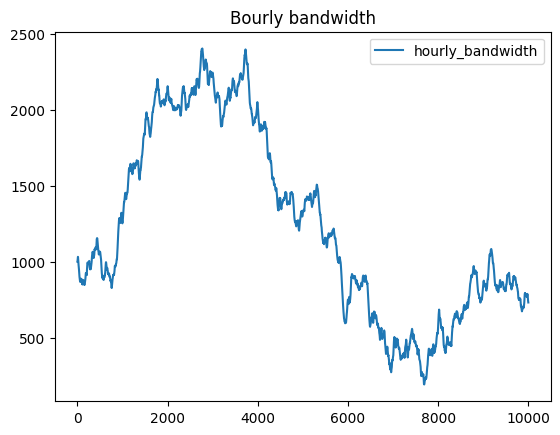

In [4]:
df.plot(title= 'Bourly bandwidth')
plt.show()

In [5]:
#Test for stationarity

ADF_result = adfuller(df['hourly_bandwidth'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -0.8714653199451994
p-value: 0.7972240255014788


In [6]:
#p-value > 0.05 => time series not stationary

bandwidth_diff = np.diff(df['hourly_bandwidth'], n=1)

In [7]:
ADF_result = adfuller(bandwidth_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -20.694853863789028
p-value: 0.0


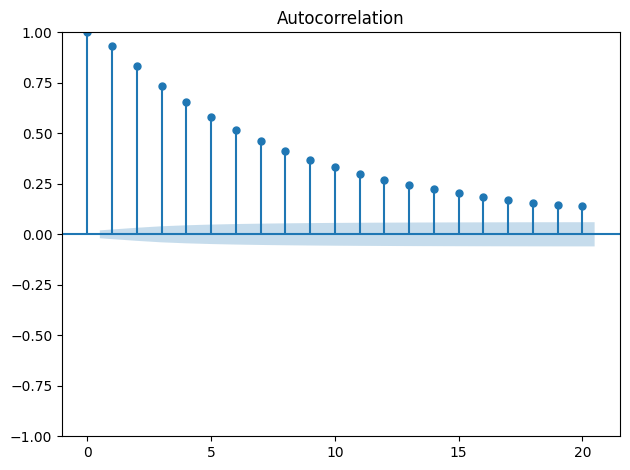

In [8]:
#Autocorrelation function - ACF plot

plot_acf(bandwidth_diff, lags=20);
plt.tight_layout()

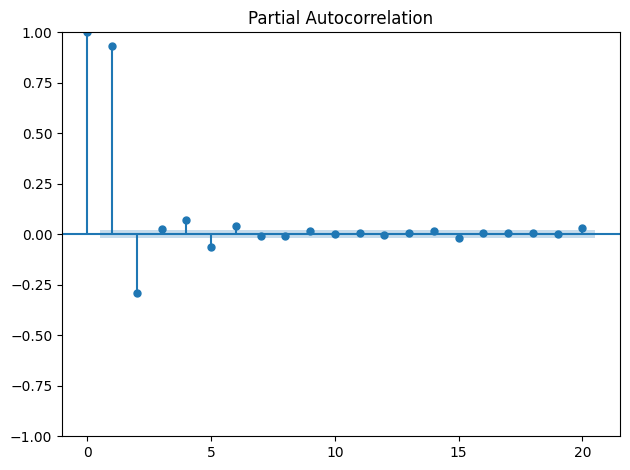

In [9]:
#Partial Autocorrelation function - PACF plot

plot_pacf(bandwidth_diff, lags=20);
plt.tight_layout()

In [10]:
#Test Set: last 7 days of data, 168 hours( 7 days x 24h)

#The model is created with the difference series.
df_diff = pd.DataFrame({'bandwidth_diff': bandwidth_diff})

train = df_diff[:-168]
test = df_diff[-168:]

print(len(train))
print(len(test))

9831
168


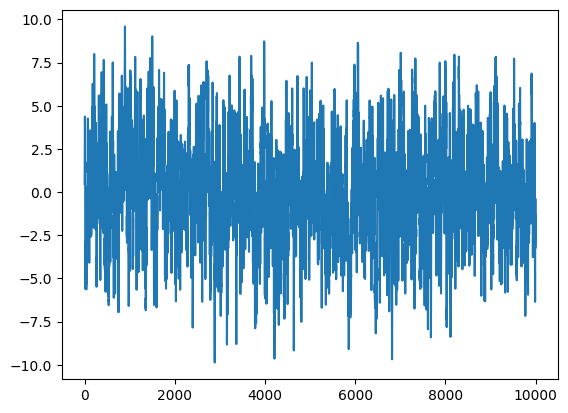

In [11]:
df_diff['bandwidth_diff'].plot()
plt.show()

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARMA(data, order_list):
    results = []

    for order in order_list:
        try:
            model = SARIMAX(data, order =(order[0],0,order[1]), simple_difference = False).fit(disp=False)
        except:
             continue
        
        aic = model.aic
        results.append([order,aic])
    
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df


In [13]:
from itertools import product
ps = range(0,4,1)
print('ps',ps)
qs = range(0,4,1)
print('qs',qs)
order_list = list(product(ps, qs))
print('order_list:\n', order_list[:3])
print('\n....')
print(order_list[-3:])
print(len(order_list))

result_df = optimize_ARMA(train['bandwidth_diff'],order_list)
result_df

ps range(0, 4)
qs range(0, 4)
order_list:
 [(0, 0), (0, 1), (0, 2)]

....
[(3, 1), (3, 2), (3, 3)]
16


,"(p,q)",AIC
0,"(3, 2)",27991.063879
1,"(2, 3)",27991.287509
2,"(2, 2)",27991.603598
3,"(3, 3)",27993.416924
4,"(1, 3)",28003.349550
5,"(1, 2)",28051.351401
6,"(3, 1)",28071.155496
7,"(3, 0)",28095.618186
8,"(2, 1)",28097.250766
9,"(2, 0)",28098.407664


                               SARIMAX Results                                
Dep. Variable:         bandwidth_diff   No. Observations:                 9831
Model:               SARIMAX(3, 0, 2)   Log Likelihood              -13989.532
Date:                Wed, 15 Nov 2023   AIC                          27991.064
Time:                        22:09:21   BIC                          28034.224
Sample:                             0   HQIC                         28005.686
                               - 9831                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3532      0.053      6.668      0.000       0.249       0.457
ar.L2          0.4150      0.066      6.250      0.000       0.285       0.545
ar.L3          0.0546      0.036      1.530      0.1

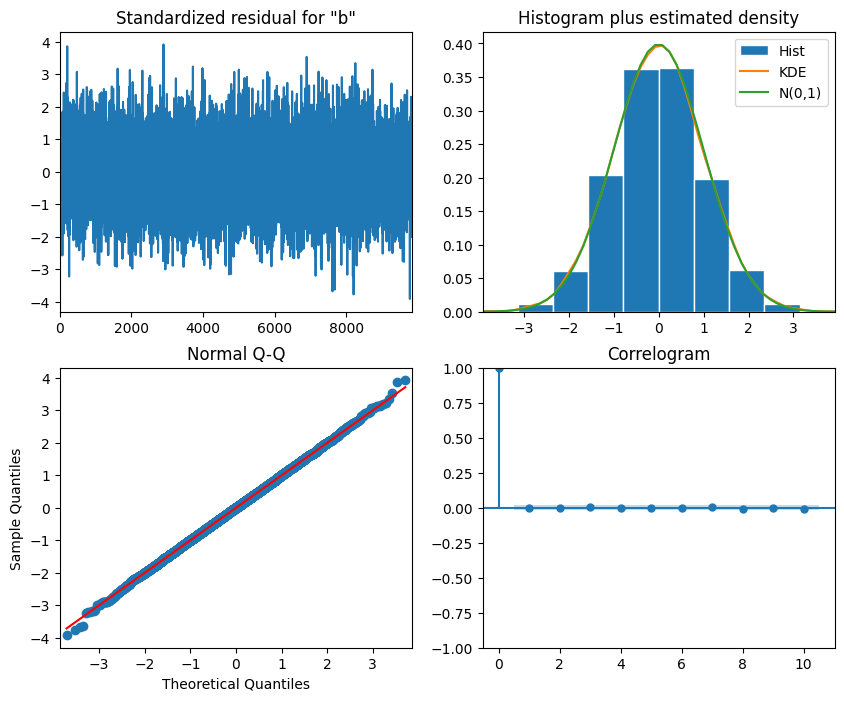

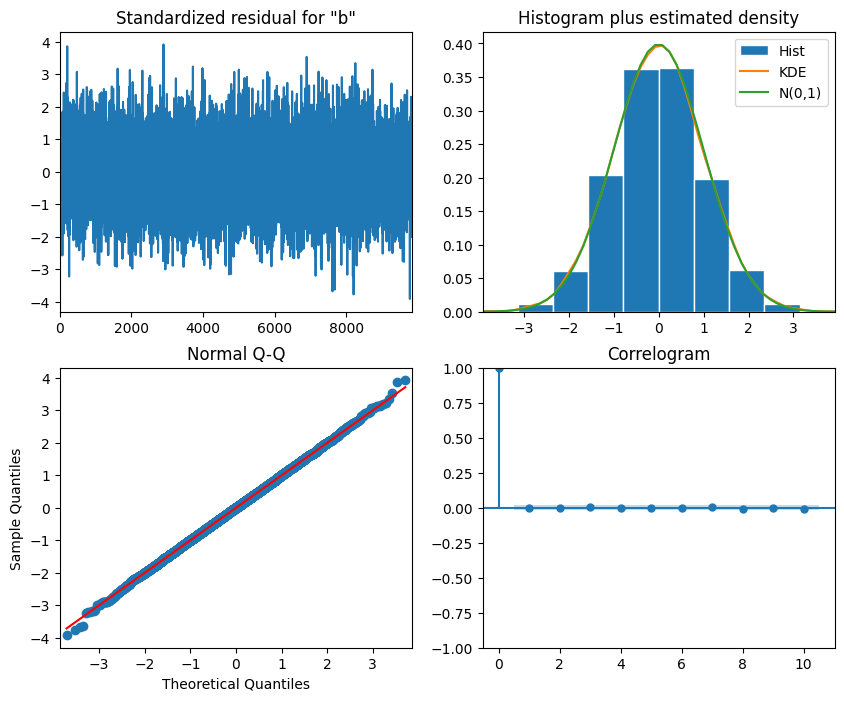

In [14]:
model = SARIMAX(train['bandwidth_diff'], order=(3, 0, 2), simple_differencing=False)

model_fit = model.fit(disp=False)

print(model_fit.summary())

model_fit.plot_diagnostics(figsize=(10, 8))

In [15]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = model_fit.resid
residuals_test = acorr_ljungbox(residuals, np.arange(1, 11, 1))

residuals_test['lb_pvalue']

1     0.978461
2     0.992353
3     0.997508
4     0.999201
5     0.997428
6     0.999154
7     0.999614
8     0.994917
9     0.997995
10    0.997236
Name: lb_pvalue, dtype: float64

In [16]:
def rolling_forecast(df, train_len, horizon, window, method):
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value =[]

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method =='ARMA':
        pred_ARMA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2, 0, 2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window -1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)

        return pred_ARMA

In [17]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

In [22]:
from sklearn.metrics import mean_squared_error

mse_mean  = mean_squared_error(test['bandwidth_diff'], test['pred_mean'])
mse_last  = mean_squared_error(test['bandwidth_diff'], test['pred_last_value'])
mse_ARMA  = mean_squared_error(test['bandwidth_diff'], test['pred_ARMA'])

print('MSE historical Mean', round(mse_mean, 3))
print('MSE last value', round(mse_last, 3))
print('MSE ARMA(2)', round(mse_ARMA, 3))

MSE historical Mean 6.307
MSE last value 2.23
MSE ARMA(2) 1.769


In [24]:
df['pred_bandwidth'] = pd.Series()
df['pred_bandwidth'][9832:] = df['hourly_bandwidth'].iloc[9832] + test['pred_ARMA'].cumsum()
df

,hourly_bandwidth,pred_bandwidth
0,1000.496714,NaN
1,1000.969408,NaN
2,1002.046019,NaN
3,1004.702118,NaN
4,1007.447816,NaN
...,...,...
9995,740.546059,721.377109
9996,738.906228,721.70246
9997,736.057995,721.996748
9998,733.559640,719.020898


In [25]:
plt.rcParams['figure.figsize'] = (10, 6)

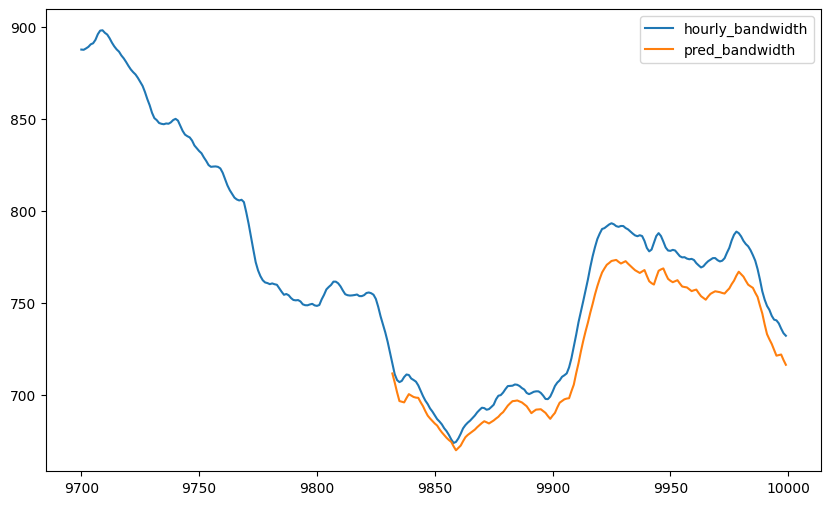

In [27]:
df.iloc[-300:].plot()
plt.show()

In [29]:
from sklearn.metrics import mean_absolute_error

mse_ARMA_undiff = mean_absolute_error(df['hourly_bandwidth'][9832:], df['pred_bandwidth'][9832:])
print(mse_ARMA_undiff)

df['hourly_bandwidth'].describe()

14.000362772816308


count    10000.000000
mean      1232.634448
std        615.204936
min        193.079868
25%        751.099777
50%       1064.494357
75%       1896.875640
max       2402.361236
Name: hourly_bandwidth, dtype: float64